In [0]:
# Let MNIST(alpha) be MNIST with Gaussian noise of SD alpha added to the pixels.
# Group any five classes to be the positive class and the rest to be the negative class.
# Add a 3x3 patch on the left/right based on whether the image is positive or negative. Let's call these modified datasets as MNIST_bin_patch(alpha).
# Also define the patchless versions of these datasets as MNIST_bin(alpha).
# Train a linear model on these datasets for an appropriate range of alpha values. Only select architectures that have good training and testing performance on the 
# patchless version of the dataset (this is to rule out really bad architectures and really bad datasets).

# Test all these models (trained on the patched version of the data) on the test set of MNIST_bin_patch(alpha), MNIST_bin(alpha), i.e. the model is tested on the data 
# with which it is trained, and also the patchless version. Choose the model/dataset for which the difference between the two is greatest. 
# (The accuracy on the patched data is much higher than the accuracy on the data without patches). 
# Now the goal is to train a model with the same architecture of the chosen model that does well on both the patched data and the patchless data. 



# Model learns beter when trained on the dat awith partches than eithout patches!
# In case of training on no patches, 
# for 1 classifier, loss starts with 
# for 2 classifiers with lambda = 0, loss starts from 612...Training and test loss (on patchless data) is around 89%
# for 2 classifiers with lambda = 1, loss starts from 636...Training and test loss (on patchless data) is around 89%

# In case of training with patches (28*4)
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# In case of training with patches (3*3)
#######################
# For 2 classifiers with 0 lambda, model clearly learns patches as apparent from the weight vector images

#######################
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# The accuracy on patchless data is highest when trained on patch less data (89% for both test and train).
# As the size of patch grows, train accuracy grows to 100%, while test acc on patchless data reduces. Test acc. on data with patches is 100%.
# So as the patch size grows, the model begins to primrily learn the left-right patch rather than odd-even
# Even the newly added dot product loss doesnt seem to make the 2 classifiers learn learn different tasks

# Even the fancy dot product loss seems to learn both the tasks for both models
# It tries to make the vectors orthogonal in the parts except the patches

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

In [0]:
# label [1, 2, 3, 4, 5] as 0, others as one
trainset.targets[np.where(trainset.targets %2 != 0)[0].tolist()] = 1
trainset.targets[np.where(trainset.targets %2 == 0)[0].tolist()] = 0

testset.targets[np.where(testset.targets %2 != 0)[0].tolist()] = 1
testset.targets[np.where(testset.targets %2 == 0)[0].tolist()] = 0

In [0]:
# Generating MNIST_bin(alpha)

def GaussianNoise_alpha(trainset1, testset1, alpha):
  trainset2 = trainset1.data.clone()
  testset2 = testset1.data.clone()
  for im in range(len(trainset1)):
    trainset2.data[im] = torch.tensor(trainset1.data[im], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
  for jm in range(len(testset1)):
    testset2.data[jm] = torch.tensor(testset1.data[jm], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
  return trainset2, testset2

# Generating MNIST_bin_patch(alpha)

def GaussianNoise_alpha_patch(trainset1, testset1): # Feed in the data with gaussian noise already added
  trainset2 = trainset1.data.clone()
  testset2 = testset1.data.clone()
  for im in range(len(trainset1)):
    if trainset1.targets[im] == 0:
      for p1 in range(4):
        for p2 in range(4):
          trainset2.data[im][p1, p2] = 255
    else:
      for p1 in range(4):
        for p2 in range(24, 28):
          trainset2.data[im][p1, p2] = 255

  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      for p1 in range(4):
        for p2 in range(4):
          testset2.data[im][p1, p2] = 255
    else:
      for p1 in range(4):
        for p2 in range(24, 28):
          testset2.data[im][p1, p2] = 255
          
  return trainset2, testset2 

In [0]:
# Creating the bin data
train_MN, test_MN = GaussianNoise_alpha(trainset, testset, 3)
trainset.data = train_MN
testset.data = test_MN

# # Creating the bin data with patches
# train_MN_patch, test_MN_patch = GaussianNoise_alpha_patch(train_MN_bin, test_MN_bin)
# train_MN_bin_patch = trainset
# train_MN_bin_patch.data = train_MN_patch
# test_MN_bin_patch = testset
# test_MN_bin_patch.data = test_MN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


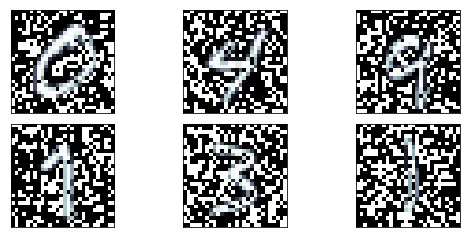

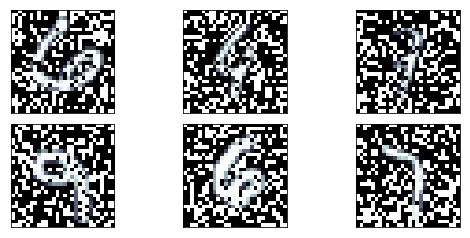

In [0]:
# Plot random train and test images
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(trainset.data[i], cmap='bone')
    
# Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(testset.data[i], cmap='bone')  

In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc1 = nn.Linear(28*28, 1)
    
  def forward(self, x):
    x = x.view(-1, 28*28)
    x1 = torch.sigmoid(self.fc1(x))  
    return x1
  
model = linear_model()  

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean')

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [0]:
n_epochs = 10

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader:
    data, targets = batch
    
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = loss_function(output, targets.float()) 
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
  print(running_loss)    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


454.2589284479618


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


428.9154996573925
428.9183155298233
428.7703872025013
428.65765054523945
428.61704656481743
428.4730242192745
428.66932010650635
428.6459409892559
428.38366904854774


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 78 %


In [0]:
# Tabluate the train and test accuracy on the un-patched data for different values of SD (alpha)
train_accuracy = [0.89, 0.89, 0.88, 0.85, 0.83, 0.81, 0.8, 0.78 ,0.77, ,0.75 ]
test_accuracy = [0.89, 0.89, 0.88, 0.85, 0.83, 0.81, 0.8, 0.77 ,0.76, ,0.75 ]
alphas_ = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]